In [1]:
import ANN
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def get_data_type(data_type):
    if data_type == 0x08:
        return np.uint8
    if data_type == 0x09:
        return np.int8
    if data_type == 0x0B:
        return np.short
    if data_type == 0x0C:
        return np.int32
    if data_type == 0x0D:
        return np.float32
    if data_type == 0x0E:
        return np.double

In [7]:
def read_data_file(path):
    with open(path, 'rb') as f:
        magic_number = f.read(4)
        data_type = get_data_type(magic_number[2])
        print(data_type)
        n_dims = int(magic_number[3])
        dimensions = []
        for dim in range(n_dims):
            dimensions.append(int.from_bytes(f.read(4), 'big'))
        print(dimensions)
        data = np.zeros(dimensions,dtype=np.uint8)
        for x in range(dimensions[0]):
            for y in range(dimensions[1]):
                for z in range(dimensions[2]):
                    data[x,y,z] = int.from_bytes(f.read(1), 'little', signed='false')
    return data

In [8]:
def read_label_file(path):
    with open(path, 'rb') as f:
        magic_number = f.read(4)
        data_type = get_data_type(magic_number[2])
        print(data_type)
        n_dims = int(magic_number[3])
        dimensions = []
        for dim in range(n_dims):
            dimensions.append(int.from_bytes(f.read(4), 'big'))
        print(dimensions)
        labels = []
        for i in range(dimensions[0]):
            labels.append(int.from_bytes(f.read(1), 'little', signed='false'))
    return np.array(labels)

In [9]:
train_data = read_data_file("data/train-images-idx3-ubyte")
test_data = read_data_file("data/t10k-images.idx3-ubyte")
train_labels = read_label_file("data/train-labels-idx1-ubyte")
test_labels = read_label_file("data/t10k-labels.idx1-ubyte")

<class 'numpy.uint8'>
[60000, 28, 28]
<class 'numpy.uint8'>
[10000, 28, 28]
<class 'numpy.uint8'>
[60000]
<class 'numpy.uint8'>
[10000]


In [10]:
print(f" Training Data ranges from {np.max(train_data)} to {np.min(train_data)}")
print(f" Test Data ranges from {np.max(test_data)} to {np.min(test_data)}")

 Training Data ranges from 255 to 0
 Test Data ranges from 255 to 0


In [11]:
def plot_sample(data, labels, title):
    fig, axs = plt.subplots(3,3)
    sample_idx = (np.random.sample(9) * data.shape[0]).astype(int)
    for i in range(len(axs.flat)):
        axs.flat[i].imshow(data[sample_idx[i]])
        axs.flat[i].set_title(labels[sample_idx[i]])
        axs.flat[i].set_xticks([])
        axs.flat[i].set_yticks([])
    fig.suptitle(title)
    fig.tight_layout()

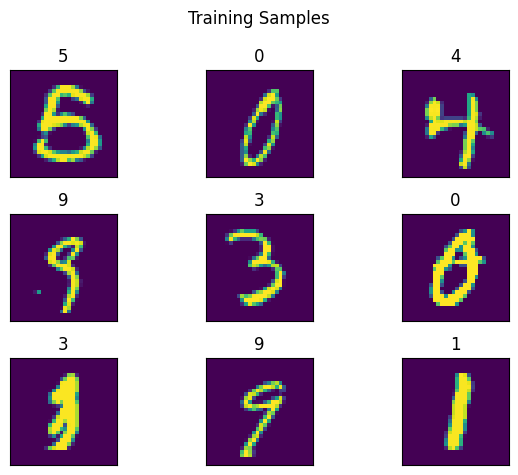

In [12]:
plot_sample(train_data, train_labels, "Training Samples")

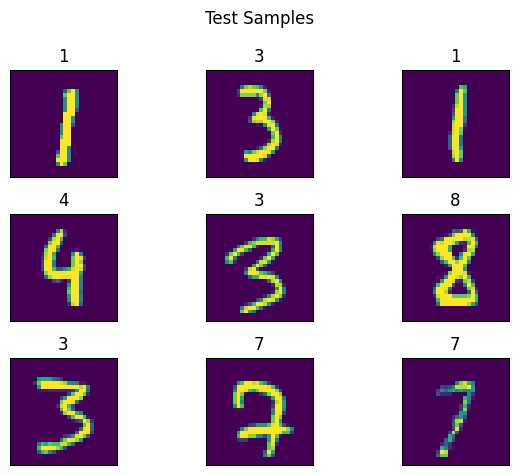

In [13]:
plot_sample(test_data, test_labels, "Test Samples")

In [14]:
train_data = train_data.reshape(-1,28,28,1)
test_data = test_data.reshape(-1,28,28,1)

In [15]:
def one_hot_encode(labels, n_labels):
    new_labels = np.zeros((labels.shape[0], n_labels))
    for i in range(labels.shape[0]):
        new_labels[i,labels[i]] = 1
    return new_labels

In [16]:
train_labels = one_hot_encode(train_labels, 10)
test_labels = one_hot_encode(test_labels, 10)

In [17]:
# Standardize data to 0 mean, unit variance using training data values.
mean = np.mean(train_data)
std = np.std(train_data)

train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

In [18]:
print(f"Training Data now has {np.around(np.mean(train_data))} mean and {np.around(np.var(train_data))} variance.")
print(f"Training Data ranges from {np.min(train_data)} to {np.max(train_data)}.")

Training Data now has -0.0 mean and 1.0 variance.
Training Data ranges from -0.424073894391566 to 2.821543345689335.


In [19]:
print(f"Validation Data now has {np.around(np.mean(test_data))} mean and {np.around(np.var(test_data))} variance.")
print(f"Data ranges from {np.min(test_data)} to {np.max(test_data)}.")

Validation Data now has 0.0 mean and 1.0 variance.
Data ranges from -0.424073894391566 to 2.821543345689335.


In [23]:
model = ANN.models.Sequential(
    [
        ANN.layers.RandomRot(10),
        ANN.layers.RandomShift(.1),
        ANN.layers.Conv2D(12, (3, 3), padding="valid", activation_function=ANN.activation_functions.ReLu()),
        ANN.layers.BatchNormalization(epsilon=1e-3, momentum=0.99),
        ANN.layers.Conv2D(24, (3, 3), padding="valid", activation_function=ANN.activation_functions.ReLu()),
        ANN.layers.MaxPool2D((2,2), (2,2), padding="valid"),
        ANN.layers.BatchNormalization(epsilon=1e-3, momentum=0.99),
        ANN.layers.Conv2D(32, (3, 3), padding="valid", activation_function=ANN.activation_functions.ReLu()),
        ANN.layers.BatchNormalization(epsilon=1e-3, momentum=0.99),
        ANN.layers.Conv2D(64, (3, 3), padding="valid", activation_function=ANN.activation_functions.ReLu()),
        ANN.layers.MaxPool2D((2,2), (2,2), padding="valid"),
        ANN.layers.BatchNormalization(epsilon=1e-3, momentum=0.99),
        ANN.layers.Conv2D(128, (3, 3), padding="valid", activation_function=ANN.activation_functions.ReLu()),
        ANN.layers.BatchNormalization(epsilon=1e-3, momentum=0.99),
        ANN.layers.Flatten(),
        ANN.layers.Dense(10, ANN.activation_functions.Softmax())
    ],
    optimizer = ANN.optimizers.Adam(learning_rate=1e-1, loss=ANN.loss_functions.CrossEntropy())
)

model.initialize_weights((1,28,28,1))

In [24]:
model.train(
    train_x=train_data,
    train_y=train_labels,
    epochs=40,
    batch_size=50,
    val_x=test_data,
    val_y=test_labels,
    shuffle=True,
    callbacks=[
        ANN.callbacks.ReduceLROnPlateau(
            patience=3,
            factor=10
        )
    ]
)

Epoch : 1


100%|██████████| 1200/1200 [01:28<00:00, 13.51it/s]


Training Loss : 0.14225399005158526
Validation Loss : 0.05206570172488781
Epoch : 2


100%|██████████| 1200/1200 [01:28<00:00, 13.57it/s]


Training Loss : 0.06449709610666415
Validation Loss : 0.06260258451817143
Epoch : 3


100%|██████████| 1200/1200 [01:28<00:00, 13.54it/s]


Training Loss : 0.05410274067281005
Validation Loss : 0.03729904762220164
Epoch : 4


100%|██████████| 1200/1200 [01:29<00:00, 13.46it/s]


Training Loss : 0.04605963040146931
Validation Loss : 0.03781463262335357
Epoch : 5


100%|██████████| 1200/1200 [01:29<00:00, 13.45it/s]


Training Loss : 0.0444169409589982
Validation Loss : 0.03179535213318875
Epoch : 6


100%|██████████| 1200/1200 [01:28<00:00, 13.51it/s]


Training Loss : 0.03907354502475597
Validation Loss : 0.027127816669731068
Epoch : 7


100%|██████████| 1200/1200 [01:29<00:00, 13.43it/s]


Training Loss : 0.03751448961706986
Validation Loss : 0.023846210884043664
Epoch : 8


100%|██████████| 1200/1200 [01:29<00:00, 13.45it/s]


Training Loss : 0.03399296385317427
Validation Loss : 0.025220681135793788
Epoch : 9


100%|██████████| 1200/1200 [01:29<00:00, 13.48it/s]


Training Loss : 0.03247695246168849
Validation Loss : 0.021933101680710342
Epoch : 10


100%|██████████| 1200/1200 [01:29<00:00, 13.39it/s]


Training Loss : 0.03170010198709754
Validation Loss : 0.020951753496013935
Epoch : 11


100%|██████████| 1200/1200 [01:29<00:00, 13.41it/s]


Training Loss : 0.02723012211558246
Validation Loss : 0.02595546800712347
Reduced learning rate to 0.01
Epoch : 12


100%|██████████| 1200/1200 [01:26<00:00, 13.91it/s]


Training Loss : 0.02268111342117437
Validation Loss : 0.019367542948666223
Epoch : 13


100%|██████████| 1200/1200 [01:25<00:00, 14.00it/s]


Training Loss : 0.020272216107231844
Validation Loss : 0.015580734786582558
Epoch : 14


100%|██████████| 1200/1200 [01:25<00:00, 14.04it/s]


Training Loss : 0.018618181446684548
Validation Loss : 0.015705304845083225
Epoch : 15


100%|██████████| 1200/1200 [01:25<00:00, 14.07it/s]


Training Loss : 0.01765190877252371
Validation Loss : 0.015546855512838948
Epoch : 16


100%|██████████| 1200/1200 [01:25<00:00, 14.04it/s]


Training Loss : 0.017372216415964835
Validation Loss : 0.015123617542573367
Epoch : 17


100%|██████████| 1200/1200 [01:25<00:00, 14.03it/s]


Training Loss : 0.017267012395007237
Validation Loss : 0.014492262177918878
Epoch : 18


100%|██████████| 1200/1200 [01:25<00:00, 13.98it/s]


Training Loss : 0.016854866897145708
Validation Loss : 0.01487817575436898
Reduced learning rate to 0.001
Epoch : 19


100%|██████████| 1200/1200 [01:25<00:00, 14.06it/s]


Training Loss : 0.015868702524034467
Validation Loss : 0.01469397990584734
Epoch : 20


100%|██████████| 1200/1200 [01:25<00:00, 14.03it/s]


Training Loss : 0.014993699485872003
Validation Loss : 0.01448091530508633
Epoch : 21


100%|██████████| 1200/1200 [01:25<00:00, 13.99it/s]


Training Loss : 0.01584303017256363
Validation Loss : 0.014407111879990575
Epoch : 22


100%|██████████| 1200/1200 [01:19<00:00, 15.06it/s]


Training Loss : 0.015443320080185879
Validation Loss : 0.014375165392166277
Epoch : 23


100%|██████████| 1200/1200 [01:16<00:00, 15.68it/s]


Training Loss : 0.016152088230248517
Validation Loss : 0.014333022848542522
Epoch : 24


100%|██████████| 1200/1200 [01:16<00:00, 15.72it/s]


Training Loss : 0.014791218231559536
Validation Loss : 0.014323842350870296
Epoch : 25


100%|██████████| 1200/1200 [01:16<00:00, 15.76it/s]


Training Loss : 0.01538781392971751
Validation Loss : 0.014125676472351687
Epoch : 26


100%|██████████| 1200/1200 [01:16<00:00, 15.75it/s]


Training Loss : 0.015560790586718087
Validation Loss : 0.014130211184055452
Epoch : 27


100%|██████████| 1200/1200 [01:16<00:00, 15.74it/s]


Training Loss : 0.01604920243291944
Validation Loss : 0.014263868032719174
Reduced learning rate to 0.0001
Epoch : 28


100%|██████████| 1200/1200 [01:16<00:00, 15.71it/s]


Training Loss : 0.015472504025295503
Validation Loss : 0.01421057859045553
Epoch : 29


100%|██████████| 1200/1200 [01:16<00:00, 15.71it/s]


Training Loss : 0.015315016763765388
Validation Loss : 0.014354926532459206
Epoch : 30


100%|██████████| 1200/1200 [01:16<00:00, 15.75it/s]


Training Loss : 0.014111428888622057
Validation Loss : 0.014340233708721926
Reduced learning rate to 1e-05
Epoch : 31


100%|██████████| 1200/1200 [01:16<00:00, 15.74it/s]


Training Loss : 0.015237006440756025
Validation Loss : 0.014159358132844073
Epoch : 32


100%|██████████| 1200/1200 [01:16<00:00, 15.76it/s]


Training Loss : 0.01541848147923494
Validation Loss : 0.014218127763468808
Epoch : 33


100%|██████████| 1200/1200 [01:16<00:00, 15.74it/s]


Training Loss : 0.01625934900457826
Validation Loss : 0.014069539215348583
Epoch : 34


100%|██████████| 1200/1200 [01:16<00:00, 15.73it/s]


Training Loss : 0.01696199119389135
Validation Loss : 0.014427874640708575
Reduced learning rate to 1.0000000000000002e-06
Epoch : 35


100%|██████████| 1200/1200 [01:16<00:00, 15.72it/s]


Training Loss : 0.016316301502744237
Validation Loss : 0.014216522830545813
Epoch : 36


100%|██████████| 1200/1200 [01:16<00:00, 15.68it/s]


Training Loss : 0.01588507843846841
Validation Loss : 0.014252645475222989
Epoch : 37


100%|██████████| 1200/1200 [01:16<00:00, 15.67it/s]


Training Loss : 0.015419464776011858
Validation Loss : 0.01407536684426627
Epoch : 38


100%|██████████| 1200/1200 [01:16<00:00, 15.68it/s]


Training Loss : 0.014950164988159846
Validation Loss : 0.014256602005986375
Reduced learning rate to 1.0000000000000002e-07
Epoch : 39


100%|██████████| 1200/1200 [01:16<00:00, 15.68it/s]


Training Loss : 0.01618281166785502
Validation Loss : 0.014211864207252475
Epoch : 40


100%|██████████| 1200/1200 [01:16<00:00, 15.65it/s]


Training Loss : 0.015057131901306425
Validation Loss : 0.01435760450215032


In [25]:
t_predictions = model.predict(train_data, batch_size=10)
val_predictions = model.predict(test_data, batch_size=10)

In [30]:
val_predictions = np.max(val_predictions, axis=1, keepdims=True) == val_predictions
t_predictions = np.max(t_predictions, axis=1, keepdims=True) == t_predictions

In [32]:
ANN.metrics.accuracy(val_predictions, test_labels)

0.9949

In [34]:
ANN.metrics.accuracy(t_predictions, train_labels)

0.997

In [35]:
training_loss = []
for key in model.history["training_loss"].keys():
    training_loss.append(model.history["training_loss"][key])
validation_loss = []
for key in model.history["validation_loss"].keys():
    validation_loss.append(model.history["validation_loss"][key])

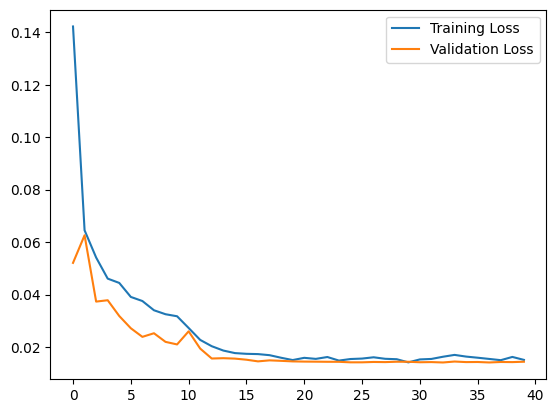

In [36]:
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.legend()
plt.show()

In [37]:
import pickle

In [38]:
with open("99_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [148]:
confusion_matrix = np.zeros((val_predictions.shape[0],val_predictions.shape[1],val_predictions.shape[1]))
confusion_matrix[np.arange(val_predictions.shape[0]), np.argmax(val_predictions,axis=1), np.argmax(test_labels,axis=1)] = 1
confusion_matrix = np.sum(confusion_matrix, axis=0).astype(int)

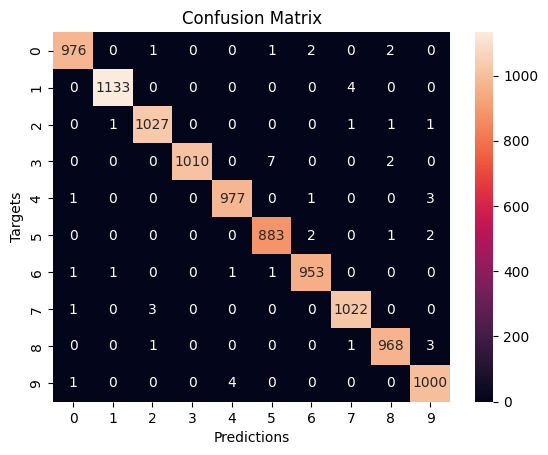

In [149]:
from seaborn import heatmap
map = heatmap(confusion_matrix, annot=True, fmt=".4g")
map.set(title="Confusion Matrix", xlabel="Predictions", ylabel="Targets")
plt.show()